# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array over several years propagating northwards (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line, initially for 2 years. Each particle has an associated transport normal to OSNAP, which I use to estimate the contribution to volumes/heat/salt crossing OSNAP northwards from the two main routes - Gulf Stream and Labrador Sea. And see how that changes over the years from 2006 to 2017.

The main conclusion is that from about 2012 Labrador Sea becomes a more important source of surface waters to the Iceland Basin, but there is also a reduction in the temperature and salinity of the water from the Gulf Stream. So probably a balance of both. **But I need to run the particles back further - 2 years is not long enough to pinpoint the pathway for most particles.**

## Technical preamble

In [29]:
import os as os
os.environ['HTTP_PROXY']="http://www-cache.geomar.de:8080"
os.environ['HTTPS_PROXY']="https://www-cache.geomar.de:8080"

In [30]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
from xhistogram.xarray import histogram

sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=20) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [3]:
## Parameters
# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/osnap/') 
filename_tracks = [
                   'tracks_osnap_backward_200607_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_200707_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_200807_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_200907_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201007_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201107_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201207_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201307_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201407_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201507_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201607_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201707_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_200601_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_200701_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_200801_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_200901_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201001_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201101_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201201_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201301_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201401_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201501_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201601_N2931_D1460_Rnd123.nc',
                   'tracks_osnap_backward_201701_N2931_D1460_Rnd123.nc'
]

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/sections/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

degree2km = 1.852*60.0


# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

# osnap_section_length = 3594572.87839    # m
# osnap_section_depth = 4000 # m over which particles launched

# osnap_section_ocean_area = osnap_section_length * osnap_section_depth * 19886.0 / 39995.0

# particle_section_area = osnap_section_length * osnap_section_depth / 39995.0

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 1121724.76238   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 500 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * 2931.0 / 3119.0

particle_section_area = osnap_subsection_length * osnap_subsection_depth / 3119.0


## Load data

### mesh and masks

In [4]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

### section position data

In [5]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

In [6]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

### tracks

In [7]:
for i,filename in enumerate(filename_tracks):
    dst=xr.open_dataset(project_path / path_data_tracks / filename)
    if i == 0:
        ds=dst
    else:
        ds=xr.concat([ds,dst],dim='traj')


#### Subset tracks by OSNAP line cross longitude and depth range

In [8]:
lonRange=[-30,-19]
depthRange=[0,500]

In [9]:
ds = ds.where((ds.isel(obs=0).lon > lonRange[0]) & (ds.isel(obs=0).lon < lonRange[1]))
ds = ds.where((ds.isel(obs=0).z > depthRange[0]) & (ds.isel(obs=0).z < depthRange[1]))
ds = ds.dropna('traj', how='all')
    

#### Velocity conversions from degrees lat/lon per second to m/s

In [10]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

#### Extract fields on osnap line (obs=0). Find 'initial' velocities normal to the section.

These are the positions we 'initialised' the particles with, but we ran particles backwards in time so these  represent the final positions, on the osnap line.

In [11]:
ds_init = ds.isel(obs=0)

In [12]:
ds_start = ds.isel(obs=-1)

In [13]:
ds_init = ds_init.assign({'section_index':xr.DataArray(np.searchsorted(lonlat.lon,ds_init.lon)-1,dims='traj')})
ds_init = ds_init.assign({'u_normal':ds_init.vvel_ms * lonlatdiff.costheta[ds_init.section_index].data - ds_init.uvel_ms * lonlatdiff.sintheta[ds_init.section_index].data})
ds_init = ds_init.assign({'u_along':ds_init.vvel_ms * lonlatdiff.sintheta[ds_init.section_index].data + ds_init.uvel_ms * lonlatdiff.costheta[ds_init.section_index].data})


#### Find along-section distances of initial points

In [14]:
ds_init = ds_init.assign({'x':xr.DataArray(length_west[ds_init.section_index] + lonlatdiff.length[ds_init.section_index]*
                              (ds_init.lon - lonlat.lon[ds_init.section_index])/lonlatdiff.lon[ds_init.section_index],dims='traj')})

### volume, temperature and salt transports along track

In [15]:
# at osnap line
ds_init = ds_init.assign({'particle_vol':(ds_init.salt/ds_init.salt) * particle_section_area/1.0e06})
ds_init = ds_init.assign({'vol_trans_normal':ds_init.u_normal * particle_section_area/1.0e06})
ds_init = ds_init.assign({'temp_transport':ds_init.temp * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'salt_transport':ds_init.salt * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'depth_transport':ds_init.z * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'lon_transport':ds_init.lon * ds_init.vol_trans_normal})

# full track assuming alongtrack volume transport conserved following particle
ds = ds.assign({'temp_transport':ds.temp * ds_init.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds_init.vol_trans_normal})
ds = ds.assign({'vol_transport':ds_init.vol_trans_normal * ds.salt/ds.salt}) # trick to get full array dimensions

In [16]:
ds_init

<xarray.Dataset>
Dimensions:           (traj: 44376)
Dimensions without coordinates: traj
Data variables:
    trajectory        (traj) float64 0.0 3.0 4.0 ... 3.113e+03 3.115e+03
    time              (traj) datetime64[ns] 2006-07-16T12:00:00 ... 2017-01-16T12:00:00
    lat               (traj) float64 58.29 58.42 58.28 ... 57.9 57.91 57.98
    lon               (traj) float64 -29.02 -29.49 -28.94 ... -19.87 -20.92
    z                 (traj) float64 217.5 262.9 223.1 ... 427.2 211.6 147.0
    temp              (traj) float32 9.849611 9.397423 ... 9.602914 9.158634
    salt              (traj) float32 35.254807 35.217884 ... 34.980053 34.88818
    uvel              (traj) float32 -3.961873e-07 ... -4.105909e-07
    vvel              (traj) float32 1.2170506e-06 ... 5.629306e-07
    uvel_ms           (traj) float64 -0.02314 -0.01731 ... 0.07491 -0.02419
    vvel_ms           (traj) float32 0.13523866 0.16043037 ... 0.06255285
    section_index     (traj) int64 6 6 6 6 6 6 6 6 6 6 6 ... 9 9 9 9 9 9 9 9 9 9
    u_normal          (traj) float64 0.111 0.1362 0.08934 ... 0.09854 0.05935
    u_along           (traj) float64 -0.08062 -0.08655 -0.074 ... 0.064 -0.03123
    x                 (traj) float64 2.194e+03 2.164e+03 ... 2.74e+03 2.677e+03
    particle_vol      (traj) float32 0.17982122 0.17982122 ... 0.17982122
    vol_trans_normal  (traj) float64 0.01996 0.02449 0.01607 ... 0.01772 0.01067
    temp_transport    (traj) float64 0.1966 0.2301 0.1587 ... 0.1702 0.09775
    salt_transport    (traj) float64 0.7038 0.8624 0.5666 ... 0.6198 0.3724
    depth_transport   (traj) float64 4.342 6.437 3.585 ... 8.823 3.749 1.569
    lon_transport     (traj) float64 -0.5793 -0.7223 -0.465 ... -0.3521 -0.2233
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

## Plot section

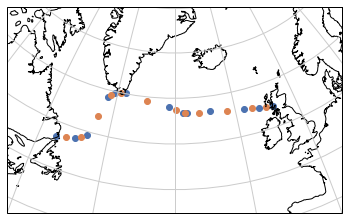

In [17]:
sns.set(style="whitegrid")
central_lon, central_lat = -30, 55
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
extent = [-60, 0, 40, 70]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')

lonlat.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat')
lonlat2mean.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat');

## Find track source regions

In [18]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected while they are in a selected area.
    '''
    # particles are selected if they pass through given area.
    position =  ((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                        
    return position > 0.0, position < 0

#### identify tracks from Labrador sea or from Gulf Stream

In [19]:
# labrador sea
ds_in1, ds_notin1 = apply_left_of_line(ds,-75,-40,40,65)
ds_in2, ds_notin2 = apply_left_of_line(ds,-95,-60,52,52)
ds_lab_sea_in = ds_in1*ds_in2

# gulf stream
ds_in, ds_notin = apply_left_of_line(ds,-60,-100,33,33)
ds_60w_in = ds_in


In [20]:
# particles on osnap line
ds_init_labsea = ds_init.where(ds_lab_sea_in.max("obs"))
ds_init_60w = ds_init.where((ds_60w_in.max("obs")) & (ds_lab_sea_in.max("obs")==False))
ds_init_other = ds_init.where((ds_60w_in.max("obs")==False) & (ds_lab_sea_in.max("obs")==False))

# particles throughout tracking timespan
ds_lab_sea = ds.where(ds_lab_sea_in.max("obs"))
ds_60w = ds.where((ds_60w_in.max("obs")) & (ds_lab_sea_in.max("obs")==False))
ds_other = ds.where((ds_lab_sea_in.max("obs")==False) & (ds_60w_in.max("obs")==False))

In [21]:
# particles on osnap line
ds_start_other = ds_start.where((ds_60w_in.max("obs")==False) & (ds_lab_sea_in.max("obs")==False))


## Transports

### Near-surface (0-500 m ) transport northwards across the OSNAP section in the Iceland Basin (30-20 W). Plotted by particle source

In [22]:
def plot_transports_by_source():

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(4,figsize = (9,12),sharex=True)

    ds_init.groupby("time").sum().particle_vol.plot(ax=ax[0],label='total')
    ds_init_labsea.groupby("time").sum().particle_vol.plot(ax=ax[0],label='labrador sea')
    ds_init_60w.groupby("time").sum().particle_vol.plot(ax=ax[0],label='gulf stream')
    ds_init_other.groupby("time").sum().particle_vol.plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('volume [$m^3 x 10^6$]')
    ax[0].set_xlabel('')

    ds_init.groupby("time").sum().vol_trans_normal.plot(ax=ax[1],label='total')
    ds_init_labsea.groupby("time").sum().vol_trans_normal.plot(ax=ax[1],label='labrador sea')
    ds_init_60w.groupby("time").sum().vol_trans_normal.plot(ax=ax[1],label='gulf stream')
    ds_init_other.groupby("time").sum().vol_trans_normal.plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('transport [Sv]')
    ax[1].set_xlabel('')

    ds_init.groupby("time").sum().temp_transport.plot(ax=ax[2],label='total')
    ds_init_labsea.groupby("time").sum().temp_transport.plot(ax=ax[2],label='labrador sea')
    ds_init_60w.groupby("time").sum().temp_transport.plot(ax=ax[2],label='gulf stream')
    ds_init_other.groupby("time").sum().temp_transport.plot(ax=ax[2],label='other')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[2].set_xlabel('')

    ds_init.groupby("time").sum().salt_transport.plot(ax=ax[3],label='total')
    ds_init_labsea.groupby("time").sum().salt_transport.plot(ax=ax[3],label='labrador sea')
    ds_init_60w.groupby("time").sum().salt_transport.plot(ax=ax[3],label='gulf stream')
    ds_init_other.groupby("time").sum().salt_transport.plot(ax=ax[3],label='other')
    lgd=ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('salt transport [Sv PSU]')

    title=fig.suptitle('Volumes and transports across OSNAP line by source. 30 to 19 $\degree$W, upper 500 m.')
    
#     plt.savefig('plot_transports_by_source.eps', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('plot_transports_by_source.png', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('plot_transports_by_source.pdf', bbox_extra_artists=(lgd,title), bbox_inches='tight')
    
    
    return


In [23]:
def plot_volumes_by_source():

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,10),sharex=True)

    ds_init.groupby("time").sum().particle_vol.plot(ax=ax[0],label='total')
    ds_init_labsea.groupby("time").sum().particle_vol.plot(ax=ax[0],label='labrador sea')
    ds_init_60w.groupby("time").sum().particle_vol.plot(ax=ax[0],label='gulf stream')
    ds_init_other.groupby("time").sum().particle_vol.plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('volume [$m^3 x 10^6$]')
    ax[0].set_xlabel('')

    ds_init.groupby("time").sum().temp_transport.plot(ax=ax[1],label='total')
    ds_init_labsea.groupby("time").sum().temp_transport.plot(ax=ax[1],label='labrador sea')
    ds_init_60w.groupby("time").sum().temp_transport.plot(ax=ax[1],label='gulf stream')
    ds_init_other.groupby("time").sum().temp_transport.plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')

    ds_init.groupby("time").sum().salt_transport.plot(ax=ax[2],label='total')
    ds_init_labsea.groupby("time").sum().salt_transport.plot(ax=ax[2],label='labrador sea')
    ds_init_60w.groupby("time").sum().salt_transport.plot(ax=ax[2],label='gulf stream')
    ds_init_other.groupby("time").sum().salt_transport.plot(ax=ax[2],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')

    title=fig.suptitle('Volume on OSNAP line by source. 30 to 19 $\degree$W, upper 500 m.')
    
#     plt.savefig('plot_volumes_by_source.eps', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('plot_volumes_by_source.png', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('plot_volumes_by_source.pdf', bbox_extra_artists=(lgd,title), bbox_inches='tight')
    
    
    return


Notice the larger difference between volume transports originating from the Gulf Stream and from the Labrador Sea in the period 2006-2011, and smaller difference after 2012.

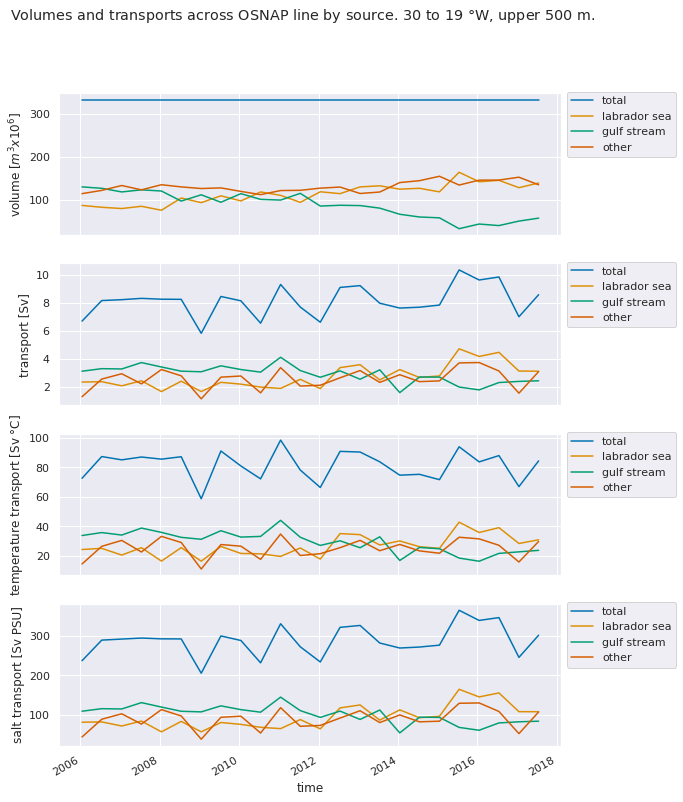

In [24]:
plot_transports_by_source()

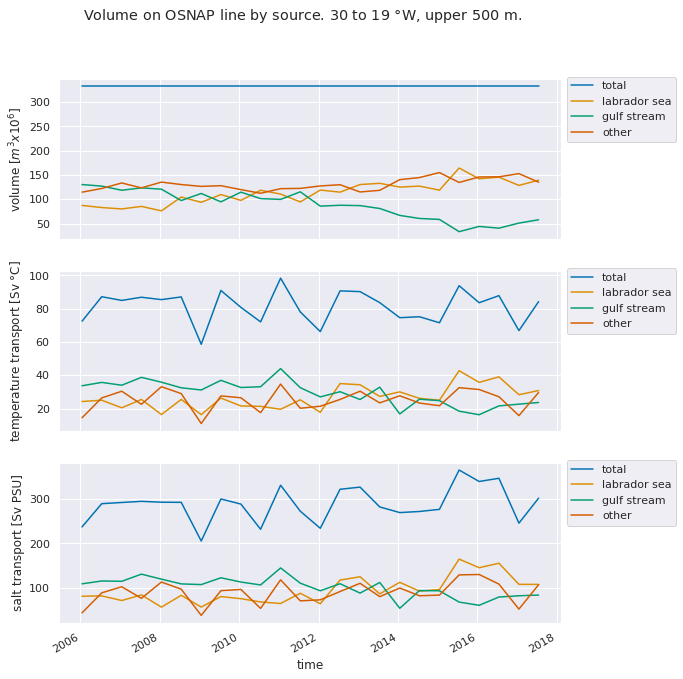

In [25]:
plot_volumes_by_source()

In [26]:
def plot_transportweighted_mean_properties_by_source():
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(4,figsize = (8,10),sharex=True)

    dsigts=ds_init.groupby("time").sum()
    dsigts_labsea=ds_init_labsea.groupby("time").sum()
    dsigts_60w=ds_init_60w.groupby("time").sum()
    dsigts_other=ds_init_other.groupby("time").sum()

    
    (dsigts.temp_transport/dsigts.vol_trans_normal).plot(ax=ax[0],label='total')
    (dsigts_labsea.temp_transport/dsigts_labsea.vol_trans_normal).plot(ax=ax[0],label='labrador sea')
    (dsigts_60w.temp_transport/dsigts_60w.vol_trans_normal).plot(ax=ax[0],label='gulf stream')
    (dsigts_other.temp_transport/dsigts_other.vol_trans_normal).plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('mean temperature [$\degree$C]')
    ax[0].set_xlabel('')

    (dsigts.salt_transport/dsigts.vol_trans_normal).plot(ax=ax[1],label='total')
    (dsigts_labsea.salt_transport/dsigts_labsea.vol_trans_normal).plot(ax=ax[1],label='labrador sea')
    (dsigts_60w.salt_transport/dsigts_60w.vol_trans_normal).plot(ax=ax[1],label='gulf stream')
    (dsigts_other.salt_transport/dsigts_other.vol_trans_normal).plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean salinity [PSU]')
    ax[1].set_xlabel('')
    
    (dsigts.depth_transport/dsigts.vol_trans_normal).plot(ax=ax[2],label='total')
    (dsigts_labsea.depth_transport/dsigts_labsea.vol_trans_normal).plot(ax=ax[2],label='labrador sea')
    (dsigts_60w.depth_transport/dsigts_60w.vol_trans_normal).plot(ax=ax[2],label='gulf stream')
    (dsigts_other.depth_transport/dsigts_other.vol_trans_normal).plot(ax=ax[2],label='other')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean depth [m]')
    ax[2].invert_yaxis()
    ax[2].set_xlabel('')

    (dsigts.lon_transport/dsigts.vol_trans_normal).plot(ax=ax[3],label='total')
    (dsigts_labsea.lon_transport/dsigts_labsea.vol_trans_normal).plot(ax=ax[3],label='labrador sea')
    (dsigts_60w.lon_transport/dsigts_60w.vol_trans_normal).plot(ax=ax[3],label='gulf stream')
    (dsigts_other.lon_transport/dsigts_other.vol_trans_normal).plot(ax=ax[3],label='other')
    lgd = ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean longitude [$\degree$E]')
    ax[3].set_xlabel('')

    title=fig.suptitle('transportweighted_mean_properties_by_source')
#     plt.savefig('transportweighted_mean_properties_by_source.eps', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('transportweighted_mean_properties_by_source.png', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('transportweighted_mean_properties_by_source.pdf', bbox_extra_artists=(lgd,title), bbox_inches='tight')
    
    
    return

In [27]:
def plot_mean_properties_by_source():
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (8,13),sharex=True)

    dsigtm=ds_init.groupby("time").mean()
    dsigtm_labsea=ds_init_labsea.groupby("time").mean()
    dsigtm_60w=ds_init_60w.groupby("time").mean()
    dsigtm_other=ds_init_other.groupby("time").mean()

        
#     ds_init.groupby("time").sum().particle_vol.plot(ax=ax[0],label='total')
    ds_init_labsea.groupby("time").sum().particle_vol.plot(ax=ax[0],label='labrador sea',color='C1')
    ds_init_60w.groupby("time").sum().particle_vol.plot(ax=ax[0],label='gulf stream',color='C2')
    ds_init_other.groupby("time").sum().particle_vol.plot(ax=ax[0],label='other',color='C3')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('volume [$m^3 x 10^6$]')
    ax[0].set_xlabel('')
    ax[0].set_ylim((0,200))

    dsigtm.temp.plot(ax=ax[1],label='total')
    dsigtm_labsea.temp.plot(ax=ax[1],label='labrador sea')
    dsigtm_60w.temp.plot(ax=ax[1],label='gulf stream')
    dsigtm_other.temp.plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    dsigtm.salt.plot(ax=ax[2],label='total')
    dsigtm_labsea.salt.plot(ax=ax[2],label='labrador sea')
    dsigtm_60w.salt.plot(ax=ax[2],label='gulf stream')
    dsigtm_other.salt.plot(ax=ax[2],label='other')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')

    dsigtm.z.plot(ax=ax[3],label='total')
    dsigtm_labsea.z.plot(ax=ax[3],label='labrador sea')
    dsigtm_60w.z.plot(ax=ax[3],label='gulf stream')
    dsigtm_other.z.plot(ax=ax[3],label='other')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean depth [m]')
    ax[3].invert_yaxis()
    ax[3].set_xlabel('')
    
    dsigtm.lon.plot(ax=ax[4],label='total')
    dsigtm_labsea.lon.plot(ax=ax[4],label='labrador sea')
    dsigtm_60w.lon.plot(ax=ax[4],label='gulf stream')
    dsigtm_other.lon.plot(ax=ax[4],label='other')
    lgd3 = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('mean longitude [$\degree$E]')
    ax[4].set_xlabel('')


    title=fig.suptitle('mean_properties_on_OSNAP_by_source',y=.92)
#     plt.savefig('mean_properties_by_source.eps', bbox_extra_artists=(lgd3,title), bbox_inches='tight')
#     plt.savefig('mean_properties_by_source.png', bbox_extra_artists=(lgd3,title), bbox_inches='tight')
#     plt.savefig('mean_properties_by_source.pdf', bbox_extra_artists=(lgd3,title), bbox_inches='tight')
    
    
    return

This is the average temperature and salinity, weighted with the normal volume transport, when the water crosses the OSNAP section. So it will have been modified from the water properties in the 'source' region.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

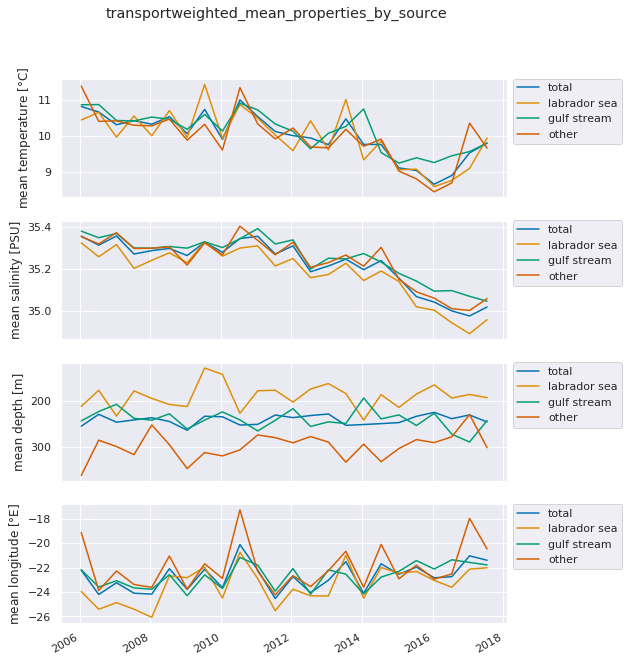

In [28]:
plot_transportweighted_mean_properties_by_source()

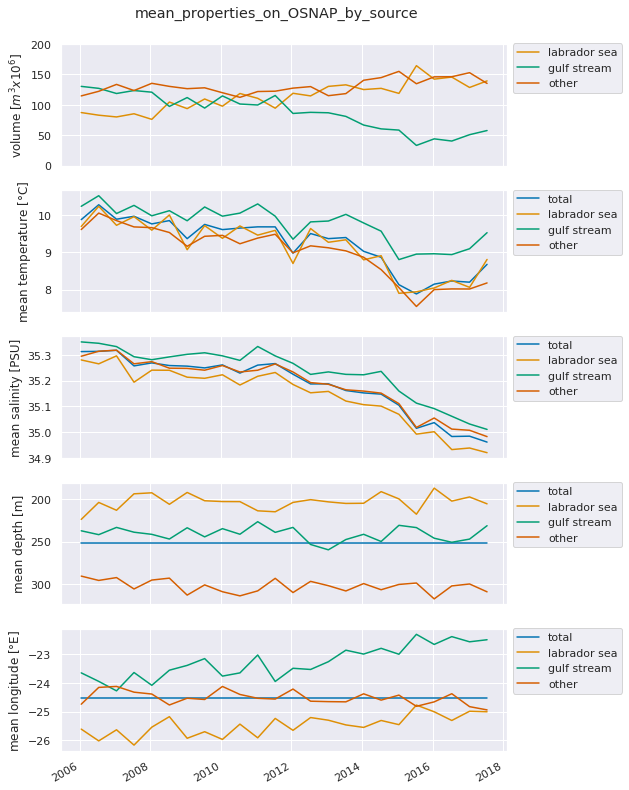

In [29]:
plot_mean_properties_by_source()

### along-track evolution of temperature and salinity

In [30]:
ds_ffill = ds.where(ds.temp!=0.0).dropna('traj', how='all').ffill(dim='obs')
ds_lab_sea_ffill = ds_lab_sea.where(ds_lab_sea.temp!=0.0).dropna('traj', how='all').ffill(dim='obs')
ds_60w_ffill = ds_60w.where(ds_60w.temp!=0.0).dropna('traj', how='all').ffill(dim='obs')
ds_other_ffill = ds_other.where(ds_other.temp!=0.0).dropna('traj', how='all').ffill(dim='obs')

ModuleNotFoundError: No module named 'bottleneck'

In [ ]:
def plot_alongtrack_av_timeseries(dsi,dsi_init,title_text):
    sns.set(style="darkgrid")
    sns.set_palette("Paired")
    
    fig,ax = plt.subplots(2,figsize = (13,12),sharex=True)

    for name,group in dsi_init.groupby("time"):
        ds_temp = dsi.where(dsi.isel(obs=0).time == name).dropna('traj', how='all')
        t=ds_temp.time.min(dim='traj')
        ax[0].plot(t,ds_temp.temp.mean(dim='traj'))
        ax[1].plot(t,ds_temp.salt.mean(dim='traj'))
        
    ax[0].set_ylim(2.5,18.5)
    ax[1].set_ylim(34.41,36.15)    
    ax[0].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_ylabel('mean salinity [PSU]')

    title=fig.suptitle(title_text + '  plot_alongtrack_av_timeseries')
    plt.savefig('plot_alongtrack_av_timeseries'+title_text+'.eps', bbox_extra_artists=(title,), bbox_inches='tight')
    plt.savefig('plot_alongtrack_av_timeseries'+title_text+'.png', bbox_extra_artists=(title,), bbox_inches='tight')
    plt.savefig('plot_alongtrack_av_timeseries'+title_text+'.pdf', bbox_extra_artists=(title,), bbox_inches='tight')
    
    return

## Mean temperature and salinity alongtrack.

Colours correspond to individual releases. Particles were tracked backwards in time, so the right-hand end of each track section is the time it crossed OSNAP line.

The idea is to try to get an idea of how much the water properties have been modified between the source region and OSNAP.


In [ ]:
plot_alongtrack_av_timeseries(ds_ffill,ds_init, 'all_particles')

In [ ]:
plot_alongtrack_av_timeseries(ds_lab_sea_ffill,ds_init_labsea, 'from_labrador_sea')

In [ ]:
plot_alongtrack_av_timeseries(ds_60w_ffill,ds_init_60w, 'from_gulf_stream')

In [ ]:
plot_alongtrack_av_timeseries(ds_other_ffill,ds_init_other, 'other_particles')

## Mean transport-weighted temperature and salinity alongtrack.

Colours correspond to individual releases. Particles were tracked backwards in time, so the right-hand end of each track section is the time it crossed OSNAP line.

The idea is to try to get an idea of how much the water properties have been modified between the source region and OSNAP.


In [ ]:
def plot_alongtrack_av_flux_timeseries(dsi,dsi_init, title_text):
    sns.set(style="darkgrid")
    sns.set_palette("Paired")

    fig,ax = plt.subplots(2,figsize = (13,12),sharex=True)

    for name,group in dsi_init.groupby("time"):
        ds_temp = dsi.where(dsi.isel(obs=0).time == name).dropna('traj', how='all')
        t = ds_temp.time.min(dim='traj')
        ax[0].plot(t,
                ds_temp.temp_transport.sum(dim='traj')/ds_temp.vol_transport.sum(dim='traj'))
        ax[1].plot(t,
                ds_temp.salt_transport.sum(dim='traj')/ds_temp.vol_transport.sum(dim='traj'))
        
    ax[0].set_ylim(2.5,18.5)
    ax[1].set_ylim(34.41,36.15)
    
    ax[0].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_ylabel('mean salinity [PSU]')

    title=fig.suptitle(title_text + '  plot_alongtrack_av_flux_timeseries')
    plt.savefig('plot_alongtrack_av_flux_timeseries'+title_text+'.eps', bbox_extra_artists=(title,), bbox_inches='tight')
    plt.savefig('plot_alongtrack_av_flux_timeseries'+title_text+'.png', bbox_extra_artists=(title,), bbox_inches='tight')
    plt.savefig('plot_alongtrack_av_flux_timeseries'+title_text+'.pdf', bbox_extra_artists=(title,), bbox_inches='tight')


In [ ]:
plot_alongtrack_av_flux_timeseries(ds_ffill,ds_init, 'all_particles')

In [ ]:
plot_alongtrack_av_flux_timeseries(ds_lab_sea_ffill,ds_init_labsea, 'from_labrador_sea')

In [ ]:
plot_alongtrack_av_flux_timeseries(ds_60w_ffill,ds_init_60w, 'from_gulf_stream')

In [ ]:
plot_alongtrack_av_flux_timeseries(ds_other_ffill,ds_init_other, 'other_particles')

### Some experimental plots

time and salinity when left Labrador Sea

In [ ]:
sns.set_palette("colorblind")
fig,ax = plt.subplots(2,figsize=(8,7))


test = ds.where(ds_lab_sea_in.max("obs")).isel(obs=ds_lab_sea_in.argmax(dim='obs'),traj=ds_lab_sea_in.traj).dropna(dim='traj', how='all')
test2 = ds_init_labsea.dropna(dim='traj', how='all')

dt = []
dtemp=[]
dsalt=[]
t=[]


for name,group in test2.groupby("time"):
    test3 = test.where(test2.time== name).dropna(dim='traj', how='all')
    
    t.append(name)
    dt.append((group.time-test3.time).mean().data.astype('timedelta64[D]').astype(int))
    dtemp.append((group.temp-test3.temp).mean().data)
    dsalt.append((group.salt-test3.salt).mean().data)
    
#     ax[0].scatter(name,(group.time-test3.time).mean().data.astype('timedelta64[D]').astype(int))
#     ax[1].scatter(name,(group.temp-test3.temp).mean().data)
#     ax[2].scatter(name,(group.salt-test3.salt).mean().data)
    
    
ax[0].plot(t,dt,color='C1')
    
pcm = ax[1].hist(x=(test2.time-test.time).data.astype('timedelta64[D]').astype(int),bins=50,color='C1')



ax[0].set_xlabel('date at OSNAP line')
ax[0].set_ylabel('mean transit time [days]')
ax[0].set_ylim((0,1100))
ax[1].set_xlabel('particle transit times [days]')
ax[1].set_ylabel('particle count')
ax[1].set_ylim((0,540))
ax[1].set_xlim((0,1500))

title=fig.suptitle('Transit of particles from Labrador Sea')
# plt.savefig('particle_transit_labsea.eps', bbox_extra_artists=(title,), bbox_inches='tight')
plt.savefig('particle_transit_labsea.png', bbox_extra_artists=(title,), bbox_inches='tight',dpi=300)
# plt.savefig('particle_transit_labsea.pdf', bbox_extra_artists=(title,), bbox_inches='tight')




In [ ]:
sns.set_palette("colorblind")
fig,ax = plt.subplots(2,figsize=(8,7))


test = ds.where(ds_60w_in.max("obs")).isel(obs=ds_60w_in.argmax(dim='obs'),traj=ds_60w_in.traj).dropna(dim='traj', how='all')
test2 = ds_init_60w.dropna(dim='traj', how='all')

dt = []
dtemp=[]
dsalt=[]
t=[]


for name,group in test2.groupby("time"):
    test3 = test.where(test2.time== name).dropna(dim='traj', how='all')
    
    t.append(name)
    dt.append((group.time-test3.time).mean().data.astype('timedelta64[D]').astype(int))
    dtemp.append((group.temp-test3.temp).mean().data)
    dsalt.append((group.salt-test3.salt).mean().data)
    
#     ax[0].scatter(name,(group.time-test3.time).mean().data.astype('timedelta64[D]').astype(int))
#     ax[1].scatter(name,(group.temp-test3.temp).mean().data)
#     ax[2].scatter(name,(group.salt-test3.salt).mean().data)
    
    
ax[0].plot(t,dt,color='C2')
    
pcm = ax[1].hist(x=(test2.time-test.time).data.astype('timedelta64[D]').astype(int),bins=50,color='C2')

ax[0].set_xlabel('date at OSNAP line')
ax[0].set_ylabel('mean transit time [days]')
ax[0].set_ylim((0,1100))
ax[1].set_xlabel('particle transit times [days]')
ax[1].set_ylabel('particle count')
ax[1].set_ylim((0,550))
ax[1].set_xlim((0,1500))


title=fig.suptitle('Transit of particles from Gulf Stream')
# plt.savefig('particle_transit_gulfstream.eps', bbox_extra_artists=(title,), bbox_inches='tight')
plt.savefig('particle_transit_gulfstream.png', bbox_extra_artists=(title,), bbox_inches='tight',dpi=300)
# plt.savefig('particle_transit_gulfstream.pdf', bbox_extra_artists=(title,), bbox_inches='tight')



In [ ]:

test_ls = ds.where(ds_lab_sea_in.max("obs")).isel(obs=ds_lab_sea_in.argmax(dim='obs'),traj=ds_lab_sea_in.traj).dropna(dim='traj', how='all')
test2_ls = ds_init_labsea.dropna(dim='traj', how='all')
test_gs = ds.where(ds_60w_in.max("obs")).isel(obs=ds_60w_in.argmax(dim='obs'),traj=ds_60w_in.traj).dropna(dim='traj', how='all')
test2_gs = ds_init_60w.dropna(dim='traj', how='all')

dt_ls = []
dtemp_ls=[]
dsalt_ls=[]
temp_start_ls=[]
salt_start_ls=[]
temp_end_ls=[]
salt_end_ls=[]
t_ls=[]

dt_gs = []
dtemp_gs=[]
dsalt_gs=[]
temp_start_gs=[]
salt_start_gs=[]
temp_end_gs=[]
salt_end_gs=[]
t_gs=[]


for name,group in test2_ls.groupby("time"):
    test3 = test_ls.where(test2_ls.time== name).dropna(dim='traj', how='all')
    
    t_ls.append(name)
    dt_ls.append((group.time-test3.time).mean().data.astype('timedelta64[D]').astype(int))
    temp_start_ls.append((test3.temp).mean().data)
    salt_start_ls.append((test3.salt).mean().data)
    temp_end_ls.append((group.temp).mean().data)
    salt_end_ls.append((group.salt).mean().data)
    dtemp_ls.append((group.temp-test3.temp).mean().data)
    dsalt_ls.append((group.salt-test3.salt).mean().data)
    
for name,group in test2_gs.groupby("time"):
    test3 = test_gs.where(test2_gs.time== name).dropna(dim='traj', how='all')
    
    t_gs.append(name)
    dt_gs.append((group.time-test3.time).mean().data.astype('timedelta64[D]').astype(int))
    temp_start_gs.append((test3.temp).mean().data)
    salt_start_gs.append((test3.salt).mean().data)
    temp_end_gs.append((group.temp).mean().data)
    salt_end_gs.append((group.salt).mean().data)
    dtemp_gs.append((group.temp-test3.temp).mean().data)
    dsalt_gs.append((group.salt-test3.salt).mean().data)
    
#     ax[0].scatter(name,(group.time-test3.time).mean().data.astype('timedelta64[D]').astype(int))
#     ax[1].scatter(name,(group.temp-test3.temp).mean().data)
#     ax[2].scatter(name,(group.salt-test3.salt).mean().data)
    

In [ ]:
sns.set_palette("colorblind")
    
fig,ax = plt.subplots(6,figsize=(8,14),sharex=True)

ax[0].plot(t,temp_start_ls,color='C1')
ax[1].plot(t,temp_end_ls,color='C1')
ax[2].plot(t,dtemp_ls,color='C1')
    

ax[0].set_ylim(2.5,5.5)
ax[1].set_ylim(7.5,10.5)
ax[2].set_ylim(3.6,6.6)

ax[0].set_xlabel('')
ax[0].set_ylabel('mean start T [$\degree$C')
ax[1].set_xlabel('')
ax[1].set_ylabel('mean end T [$\degree$C]')
ax[2].set_xlabel('')
ax[2].set_ylabel('mean deltaT [$\degree$C')

ax[3].plot(t,salt_start_ls,color='C1')
ax[4].plot(t,salt_end_ls,color='C1')
ax[5].plot(t,dsalt_ls,color='C1')
    
ax[3].set_ylim(34.3,34.9)
ax[4].set_ylim(34.85,35.45)
ax[5].set_ylim(0.25,0.85)

ax[3].set_xlabel('')
ax[3].set_ylabel('mean start S [PSU]')
ax[4].set_xlabel('')
ax[4].set_ylabel('mean end S [PSU]')
ax[5].set_xlabel('date at OSNAP line')
ax[5].set_ylabel('mean deltaS [PSU]')

title=fig.suptitle('Transit of particles from Labrador Sea',y=.9)
# plt.savefig('particle_transit_labsea_TS.eps', bbox_extra_artists=(title,), bbox_inches='tight')
plt.savefig('particle_transit_labsea_TS.png', bbox_extra_artists=(title,), bbox_inches='tight',dpi=300)
# plt.savefig('particle_transit_labsea_TS.pdf', bbox_extra_artists=(title,), bbox_inches='tight')


In [ ]:
sns.set_palette("colorblind")
    
fig,ax = plt.subplots(6,figsize=(8,14),sharex=True)

ax[0].plot(t,temp_start_gs,color='C2')
ax[1].plot(t,temp_end_gs,color='C2')
ax[2].plot(t,dtemp_gs,color='C2')
    

ax[0].set_ylim(15,18)
ax[1].set_ylim(8,11)
ax[2].set_ylim(-8.5,-5.5)

ax[0].set_xlabel('')
ax[0].set_ylabel('mean start T [$\degree$C]')
ax[1].set_xlabel('')
ax[1].set_ylabel('mean end T [$\degree$C]')
ax[2].set_xlabel('')
ax[2].set_ylabel('mean deltaT [$\degree$C]')

ax[3].plot(t,salt_start_gs,color='C2')
ax[4].plot(t,salt_end_gs,color='C2')
ax[5].plot(t,dsalt_gs,color='C2')
    

ax[3].set_ylim(35.6,36.2)
ax[4].set_ylim(34.85,35.45)
ax[5].set_ylim(-1,-0.4)

ax[3].set_xlabel('')
ax[3].set_ylabel('mean start S [PSU]')
ax[4].set_xlabel('')
ax[4].set_ylabel('mean end S [PSU]')
ax[5].set_xlabel('date at OSNAP line')
ax[5].set_ylabel('mean deltaS [PSU]')


title=fig.suptitle('Transit of particles from Gulf Stream',y=.9)
# plt.savefig('particle_transit_gs_T.eps', bbox_extra_artists=(title,), bbox_inches='tight')
plt.savefig('particle_transit_gs_TS.png', bbox_extra_artists=(title,), bbox_inches='tight',dpi=300)
# plt.savefig('particle_transit_gs_T.pdf', bbox_extra_artists=(title,), bbox_inches='tight')

## Along-track salt budget

In [ ]:
vol_total = ds_init.groupby("time").sum().particle_vol
vol_labsea = ds_init_labsea.groupby("time").sum().particle_vol
vol_60w = ds_init_60w.groupby("time").sum().particle_vol
vol_other = ds_init_other.groupby("time").sum().particle_vol

mean_salt = ds_init.salt.mean()
display(mean_salt)

salt_mass_total  = vol_total  * (ds_init.groupby("time").mean().salt - mean_salt.data)
salt_mass_labsea = vol_labsea * (ds_init_labsea.groupby("time").mean().salt - mean_salt.data)
salt_mass_60w    = vol_60w    * (ds_init_60w.groupby("time").mean().salt - mean_salt.data)
salt_mass_other  = vol_other  * (ds_init_other.groupby("time").mean().salt - mean_salt.data)

salt_mass_start_ls = vol_labsea * (np.array(salt_start_ls) - mean_salt.data)
salt_mass_start_gs = vol_60w * (np.array(salt_start_gs) - mean_salt.data)

salt_mass_start_other = vol_other  * (ds_start_other.groupby("time").mean().salt.data - mean_salt.data)

salt_mass_total.attrs['long_name']='total salt'
salt_mass_total.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_labsea.attrs['long_name']='total salt'
salt_mass_labsea.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_60w.attrs['long_name']='total salt'
salt_mass_60w.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_other.attrs['long_name']='total salt'
salt_mass_other.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_start_ls.attrs['long_name']='total salt'
salt_mass_start_ls.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_start_gs.attrs['long_name']='total salt'
salt_mass_start_gs.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_start_other.attrs['long_name']='total salt'
salt_mass_start_other.attrs['units']='PSU $\mathrm{m}^3$'


In [ ]:
sns.set_palette("colorblind")

fig,ax = plt.subplots(2,figsize=(7,7),sharex=True)


(salt_mass_total-salt_mass_total[0]).plot(ax=ax[0],label='total')
(salt_mass_labsea-salt_mass_labsea[0]).plot(ax=ax[0],label='labrador sea',color='C1')
(salt_mass_60w-salt_mass_60w[0]).plot(ax=ax[0],label='gulf stream',color='C2')
(salt_mass_other-salt_mass_other[0]).plot(ax=ax[0],label='other',color='C3')

salt_mass_transit = (salt_mass_total-(salt_mass_start_ls+salt_mass_start_gs+salt_mass_start_other))
(salt_mass_total-salt_mass_total[0]).plot(ax=ax[1],label='total')
(salt_mass_start_ls-salt_mass_start_ls[0]).plot(ax=ax[1],label='labrador sea',color='C1')
(salt_mass_start_gs-salt_mass_start_gs[0]).plot(ax=ax[1],label='gulf stream',color='C2')
(salt_mass_start_other-salt_mass_start_other[0]).plot(ax=ax[1],label='other',color='C3')
((salt_mass_transit-salt_mass_transit[0])).plot(ax=ax[1],label='transit',color='C4')


ax[0].set_xlabel('')

ax[0].legend(bbox_to_anchor=(1.0, 1.02))
lgd1 = ax[1].legend(bbox_to_anchor=(1.0, 1.02))

plt.savefig('particle_salt_budget.png', bbox_extra_artists=(lgd1,), bbox_inches='tight',dpi=300)

# ax[0].legend(bbox_to_anchor=(1.0, 1.05))
# ax[0].set_ylabel('volume [$m^3 x 10^6$]')
# ax[0].set_xlabel('')
# ax[0].set_ylim((0,200))


In [ ]:
mean_temp = ds_init.temp.mean()
display(mean_temp)

heat_total  = vol_total  * (ds_init.groupby("time").mean().temp - mean_temp.data)
heat_labsea = vol_labsea * (ds_init_labsea.groupby("time").mean().temp - mean_temp.data)
heat_60w    = vol_60w    * (ds_init_60w.groupby("time").mean().temp - mean_temp.data)
heat_other  = vol_other  * (ds_init_other.groupby("time").mean().temp - mean_temp.data)

heat_start_ls = vol_labsea * (np.array(temp_start_ls) - mean_temp.data)
heat_start_gs = vol_60w * (np.array(temp_start_gs) - mean_temp.data)

heat_start_other = vol_other  * (ds_start_other.groupby("time").mean().temp.data - mean_temp.data)

heat_total.attrs['long_name']='total heat'
heat_total.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_labsea.attrs['long_name']='total heat'
heat_labsea.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_60w.attrs['long_name']='total heat'
heat_60w.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_other.attrs['long_name']='total heat'
heat_other.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_start_ls.attrs['long_name']='total heat'
heat_start_ls.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_start_gs.attrs['long_name']='total heat'
heat_start_gs.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_start_other.attrs['long_name']='total heat'
heat_start_other.attrs['units']='$\degree$C $\mathrm{m}^3$'



In [ ]:
sns.set_palette("colorblind")

fig,ax = plt.subplots(2,figsize=(8,7),sharex=True)


(heat_total-heat_total[0]).plot(ax=ax[0],label='total')
(heat_labsea-heat_labsea[0]).plot(ax=ax[0],label='labrador sea',color='C1')
(heat_60w-heat_60w[0]).plot(ax=ax[0],label='gulf stream',color='C2')
(heat_other-heat_other[0]).plot(ax=ax[0],label='other',color='C3')

heat_transit = heat_total - (heat_start_ls+heat_start_gs+heat_start_other)
(heat_total-heat_total[0]).plot(ax=ax[1],label='total')
(heat_start_ls-heat_start_ls[0]).plot(ax=ax[1],label='labrador sea',color='C1')
(heat_start_gs-heat_start_gs[0]).plot(ax=ax[1],label='gulf stream',color='C2')
(heat_start_other-heat_start_other[0]).plot(ax=ax[1],label='other',color='C3')
(heat_transit-heat_transit[0]).plot(ax=ax[1],label='transit',color='C4')

ax[0].set_xlabel('')

ax[0].legend(bbox_to_anchor=(1.0, 1.02))
lgd1 = ax[1].legend(bbox_to_anchor=(1.0, 1.02))

plt.savefig('particle_heat_budget.png', bbox_extra_artists=(lgd1,), bbox_inches='tight',dpi=300)



In [ ]:
salt_mass_total  = vol_total  * (ds_init.groupby("time").mean().salt)
salt_mass_labsea = vol_labsea * (ds_init_labsea.groupby("time").mean().salt)
salt_mass_60w    = vol_60w    * (ds_init_60w.groupby("time").mean().salt)
salt_mass_other  = vol_other  * (ds_init_other.groupby("time").mean().salt)

salt_mass_start_ls = vol_labsea * (np.array(salt_start_ls))
salt_mass_start_gs = vol_60w * (np.array(salt_start_gs))

salt_mass_start_other = vol_other  * (ds_start_other.groupby("time").mean().salt.data)

salt_mass_total.attrs['long_name']='total salt'
salt_mass_total.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_labsea.attrs['long_name']='total salt'
salt_mass_labsea.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_60w.attrs['long_name']='total salt'
salt_mass_60w.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_other.attrs['long_name']='total salt'
salt_mass_other.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_start_ls.attrs['long_name']='total salt'
salt_mass_start_ls.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_start_gs.attrs['long_name']='total salt'
salt_mass_start_gs.attrs['units']='PSU $\mathrm{m}^3$'
salt_mass_start_other.attrs['long_name']='total salt'
salt_mass_start_other.attrs['units']='PSU $\mathrm{m}^3$'

heat_total  = vol_total  * (ds_init.groupby("time").mean().temp)
heat_labsea = vol_labsea * (ds_init_labsea.groupby("time").mean().temp)
heat_60w    = vol_60w    * (ds_init_60w.groupby("time").mean().temp)
heat_other  = vol_other  * (ds_init_other.groupby("time").mean().temp)

heat_start_ls = vol_labsea * (np.array(temp_start_ls))
heat_start_gs = vol_60w * (np.array(temp_start_gs))

heat_start_other = vol_other  * (ds_start_other.groupby("time").mean().temp.data)

heat_total.attrs['long_name']='total heat'
heat_total.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_labsea.attrs['long_name']='total heat'
heat_labsea.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_60w.attrs['long_name']='total heat'
heat_60w.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_other.attrs['long_name']='total heat'
heat_other.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_start_ls.attrs['long_name']='total heat'
heat_start_ls.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_start_gs.attrs['long_name']='total heat'
heat_start_gs.attrs['units']='$\degree$C $\mathrm{m}^3$'
heat_start_other.attrs['long_name']='total heat'
heat_start_other.attrs['units']='$\degree$C $\mathrm{m}^3$'



In [ ]:
sns.set_palette("colorblind")

fig,ax = plt.subplots(2,figsize=(7,7),sharex=True)

# salinity
final_total_sm = (salt_mass_total-salt_mass_total[0])
salt_mass_start_total = salt_mass_start_ls + salt_mass_start_gs + salt_mass_start_other
start_total_sm = (salt_mass_start_total-salt_mass_total[0])

# what if salinity was unchanged
salt_mass_start_fix_ls = vol_labsea * (np.array(salt_start_ls[0]))
salt_mass_start_fix_gs = vol_60w * (np.array(salt_start_gs[0]))
salt_mass_start_fix_other = vol_other  * (ds_start_other.groupby("time").mean().salt.data[0])
salt_mass_start_fix_total = salt_mass_start_fix_ls + salt_mass_start_fix_gs + salt_mass_start_fix_other
start_total_fixs_sm = (salt_mass_start_fix_total-salt_mass_total[0])

#temperature
final_total_hm = (heat_total-heat_total[0])
heat_start_total = heat_start_ls + heat_start_gs + heat_start_other
start_total_hm = (heat_start_total-heat_total[0])

# what if salinity was unchanged
heat_start_fix_ls = vol_labsea * (np.array(temp_start_ls[0]))
heat_start_fix_gs = vol_60w * (np.array(temp_start_gs[0]))
heat_start_fix_other = vol_other  * (ds_start_other.groupby("time").mean().temp.data[0])
heat_start_fix_total = heat_start_fix_ls + heat_start_fix_gs + heat_start_fix_other
start_total_fixt_hm = (heat_start_fix_total-heat_total[0])




final_total_hm.plot(ax=ax[0],label='at OSNAP line')
start_total_hm.plot(ax=ax[0],label='initial')
start_total_fixt_hm.plot(ax=ax[0],label='initial -- deltaV')
(start_total_hm-start_total_fixt_hm).plot(ax=ax[0],label='initial -- deltaT')
(final_total_hm-start_total_hm).plot(ax=ax[0],label='transit')

final_total_sm.plot(ax=ax[1],label='at OSNAP line')
start_total_sm.plot(ax=ax[1],label='initial')
start_total_fixs_sm.plot(ax=ax[1],label='initial -- deltaV')
(start_total_sm-start_total_fixs_sm).plot(ax=ax[1],label='initial -- deltaS')
(final_total_sm-start_total_sm).plot(ax=ax[1],label='transit')




ax[0].set_xlabel('')

ax[0].legend(bbox_to_anchor=(1.0, 1.02))
lgd1 = ax[1].legend(bbox_to_anchor=(1.0, 1.02))

plt.savefig('particle_ts_budget.png', bbox_extra_artists=(lgd1,), bbox_inches='tight',dpi=300)

# ax[0].legend(bbox_to_anchor=(1.0, 1.05))
# ax[0].set_ylabel('volume [$m^3 x 10^6$]')
# ax[0].set_xlabel('')
# ax[0].set_ylim((0,200))


In [ ]:
ds_start_other.groupby("time").mean().temp.plot()

In [ ]:
h_start_ls = vol_labsea * (np.array(temp_start_ls))
h_start_gs = vol_60w * (np.array(temp_start_gs))
h_start_other = vol_other  * ds_start_other.groupby("time").mean().temp.data

t_start_ls = h_start_ls / vol_labsea
t_start_gs = h_start_gs / vol_60w
t_start_other = h_start_other / vol_other
t_start_total = (h_start_ls + h_start_gs + h_start_other) / vol_total

s_start_ls = vol_labsea * (np.array(salt_start_ls))
s_start_gs = vol_60w * (np.array(salt_start_gs))
s_start_other = vol_other  * ds_start_other.groupby("time").mean().salt.data

sali_start_ls = s_start_ls / vol_labsea
sali_start_gs = s_start_gs / vol_60w
sali_start_other = s_start_other / vol_other
sali_start_total = (s_start_ls + s_start_gs + s_start_other) / vol_total




In [ ]:
def plot_mean_start_properties_by_source():
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(2,figsize = (8,7),sharex=True)


    t_start_total.plot(ax=ax[0],label='total',color='C0')
    t_start_ls.plot(ax=ax[0],label='labrador sea',color='C1')
    t_start_gs.plot(ax=ax[0],label='gulf stream',color='C2')
    t_start_other.plot(ax=ax[0],label='other',color='C3')

    sali_start_total.plot(ax=ax[1],label='total',color='C0')
    sali_start_ls.plot(ax=ax[1],label='labrador sea',color='C1')
    sali_start_gs.plot(ax=ax[1],label='gulf stream',color='C2')
    sali_start_other.plot(ax=ax[1],label='other',color='C3')

    dsigtm=ds_init.groupby("time").mean()
    dsigtm.temp.plot(ax=ax[0],label='final',color='k')
    
    dsigtm.salt.plot(ax=ax[1],label='final',color='k')
    lgd1 = ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean salinity [PSU]')
    ax[1].set_xlabel('')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02))
    ax[0].set_ylabel('mean temperature [$\degree$C]')
    ax[0].set_xlabel('')
    
#     plt.savefig('mean_properties_by_source.eps', bbox_extra_artists=(lgd3,title), bbox_inches='tight')
    plt.savefig('mean_start_properties_by_source.png', bbox_extra_artists=(lgd1,), bbox_inches='tight')
#     plt.savefig('mean_properties_by_source.pdf', bbox_extra_artists=(lgd3,title), bbox_inches='tight')
    
    
    return

In [ ]:
plot_mean_start_properties_by_source()


In [ ]:
vol_total_mean = vol_total.mean()
vol_total_anom = vol_total-vol_total_mean
vol_labsea_mean = vol_labsea.mean()
vol_labsea_anom = vol_labsea - vol_labsea_mean.mean(
vol_60w_mean = vol_60w.mean()
vol_60w_anom = vol_60w - vol_60w_mean
vol_other_mean = vol_other.mean()
vol_other_anom = vol_other - vol_other_mean

# salt_mass_total  = vol_total  * (ds_init.groupby("time").mean().salt - 34)
# salt_mass_labsea = vol_labsea * (ds_init_labsea.groupby("time").mean().salt - 34)
# salt_mass_60w    = vol_60w    * (ds_init_60w.groupby("time").mean().salt - 34)
# salt_mass_other  = vol_other  * (ds_init_other.groupby("time").mean().salt - 34)

# salt_mass_start_ls = vol_labsea * (np.array(salt_start_ls) - 34)
# salt_mass_start_gs = vol_60w * (np.array(salt_start_gs) - 34)

# salt_mass_start_other = vol_other  * (ds_start_other.groupby("time").mean().salt.data - 34)


In [ ]:
sns.set_palette("colorblind")

fig,ax = plt.subplots(3,figsize=(8,10),sharex=True)


vol_labsea.plot(ax=ax[0],label='total')
(vol_labsea_mean+vol_labsea-vol_labsea).plot(ax=ax[0],label='total')
vol_labsea_anom.plot(ax=ax[0],label='total')

vol_60w.plot(ax=ax[1],label='total')
(vol_60w_mean+vol_60w-vol_60w).plot(ax=ax[1],label='total')
vol_60w_anom.plot(ax=ax[1],label='total')

vol_other.plot(ax=ax[2],label='total')
(vol_other_mean+vol_other-vol_other).plot(ax=ax[2],label='total')
vol_other_anom.plot(ax=ax[2],label='total')





# salt_mass_labsea.plot(ax=ax[0],label='labrador sea',color='C1')
# salt_mass_60w.plot(ax=ax[0],label='gulf stream',color='C2')
# salt_mass_other.plot(ax=ax[0],label='other',color='C3')

# (salt_mass_start_ls+salt_mass_start_gs+salt_mass_start_other).plot(ax=ax[1],label='gulf stream',color='C0')
# salt_mass_start_ls.plot(ax=ax[1],label='labrador sea',color='C1')
# salt_mass_start_gs.plot(ax=ax[1],label='gulf stream',color='C2')
# salt_mass_start_other.plot(ax=ax[1],label='other',color='C3')

# (salt_mass_total-(salt_mass_start_ls+salt_mass_start_gs+salt_mass_start_other)).plot(ax=ax[2],label='total')
# (salt_mass_labsea-salt_mass_start_ls).plot(ax=ax[2],label='labrador sea',color='C1')
# (salt_mass_60w-salt_mass_start_gs).plot(ax=ax[2],label='gulf stream',color='C2')
# (salt_mass_other-salt_mass_start_other).plot(ax=ax[2],label='other',color='C3')




In [ ]:
(test2.time-test.time).

In [ ]:
fig,ax = plt.subplots(figsize=(14,5))

test = ds.where(ds_lab_sea_in.max("obs")).isel(obs=ds_lab_sea_in.argmax(dim='obs'),traj=ds_lab_sea_in.traj).dropna(dim='traj')
pcm = ax.scatter(x=test.time.data,y=test.salt.data)


time and salinity when left Labrador Sea

In [ ]:
fig,ax = plt.subplots(figsize=(14,5))

test = ds.where((ds_lab_sea_in.max("obs")==False)).where(ds_60w_in.max("obs")).isel(obs=ds_60w_in.argmax(dim='obs'),traj=ds_60w_in.traj).dropna(dim='traj')
pcm = ax.scatter(x=test.time.data,y=test.temp.data
                 ,c=test.salt.data,
          vmin=33,vmax=36,cmap=co.cm.haline
                )
plt.colorbar(pcm,ax=ax,label = "salinity");

# cb = plt.colorbar(label = "date");


In [1]:
conda list

# packages in environment at /opt/tljh/user/envs/py3_euler_brokenline_2020.08.20.1:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       0_gnu    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
attrs                     19.3.0                     py_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
basemap                   1.2.1            py37hd759880_1    conda-forge
bleach                    3.1.0                      py_0    conda-forge
blosc                     1.17.0               he1b5a44_1    conda-forge
bokeh                     1.4.0                    py37_0    conda-forge
boost-cpp                 1.70.0               h8e57a91_2    conda-forge
bzip2                     1.0.8                h516909a_2    conda-forge
ca-certificates           2019.11.28        